# Simulación de Atención en Urgencias (CSS Panamá)
Proyecto de curso: Simulación de Sistemas
Estudiante: Hernán Domínguez – 8-970-599  
Profesora: Lucy Pascual  

Periodo de simulación: 7×24 h (con warm-up de 2 h descartado)
Modelo: Llegada → Triage (Manchester)

---


## 1. Contexto y Motivación
En un servicio de urgencias (ED) de una comunidad con alto riesgo (violencia, alta demanda nocturna), la congestión previa al triage genera demoras críticas y abandono temprano. Cumplir tiempos objetivo por color (Manchester) es clave para seguridad y para estabilizar el flujo posterior del ED.

## 2. Problema Central
Colas extensas y variabilidad por franja (día/tarde/noche; fin de semana) ocasionan que muchos pacientes excedan tiempos objetivo antes de ser clasificados, generando abandono pre triage (LWBS_pre) y pérdida de oportunidad clínica.

## 3. Pregunta de Investigación
¿Qué combinación de tasa de dotación de enfermería de triage, reglas de prioridad por color y políticas de admisión (pre screening/derivación) reduce el door to triage y el % de pacientes que exceden el objetivo (por color), maximizando el throughput de triage por franja?


## 4. Objetivos
**General:** Diseñar y evaluar, mediante simulación, estrategias para disminuir el tiempo de espera a triage y cumplir objetivos por color.

**Específicos:**
1. Modelar llegadas por franja (día/tarde/noche; weekend/weekday) y mezcla de colores (Manchester).
2. Calibrar distribución de servicio de triage (tiempo de evaluación enfermería) y su variabilidad.
3. Comparar escenarios: dotación por franja, cola prioritaria estricta vs variantes, pre screening de azules, colas paralelas Ambulancia/Walk in.
4. Medir impacto en KPIs: door to triage (media, p50, p90), % dentro objetivo por color, longitud de cola, utilización, throughput y abandono.
5. Analizar sensibilidad a picos nocturnos y mezcla por color.


## 5. Alcance y Límites
Cobertura: Llegada → Triage (paciente atendido al completar triage). No se modela consulta médica, diagnósticos, imágenes, observación ni ingreso. Horizon: 7×24 h. Recursos: enfermería triage (1–3 por franja). Pacientes: colores Manchester (rojo, naranja, amarillo, verde, azul).

## 6. Hipótesis de Trabajo (Resumen)
1. Refuerzo nocturno reduce door to triage (media y p90) sin >85% utilización.
2. Prioridad estricta mejora cumplimiento naranja/amarillo vs FCFS.
3. Pre screening azules reduce cola y mejora throughput sin afectar críticos.
4. Separar vías Ambulancia/Walk in disminuye variabilidad en críticos.

## 7. KPIs Clave
- Door to triage (min) por color: media, p50, p90, p95.
- % dentro objetivo por color (Rojo inmediato; Naranja ≤10; Amarillo ≤60; Verde ≤120; Azul ≤240).
- Longitud media y p95 cola triage.
- Utilización enfermería (% ocupado).
- Throughput triage (pacientes/h) por franja.
- Abandono pre triage (LWBS_pre, %).


## 13. Glosario
- **Triage (Manchester):** Clasificación rápida en 5 niveles de gravedad con tiempos objetivo máximos.
- **Door to triage:** Minutos desde llegada hasta inicio del triage.
- **LWBS_pre:** Paciente abandona antes de ser clasificado.
- **Throughput:** Triage completados por unidad de tiempo.
- **Utilización:** % de tiempo total recurso ocupado.
- **FCFS:** First Come, First Served.
- **Pre screening:** Filtro administrativo inicial para derivar/no admitir casos muy leves.
- **Franja:** Bloques horarios (día/tarde/noche, fin de semana).  

---
A continuación se definen parámetros y se implementa el motor de simulación.


In [329]:
# Parámetros base y utilidades
# -------------------------------------------------------------
# Esta celda define constantes, distribuciones y funciones de apoyo.
# Todo el modelo posterior (motor, escenarios, sensibilidad) se apoya en ellas.
# -------------------------------------------------------------

# Importaciones estándar
import math  # operaciones matemáticas (log, sqrt)
import random  # generador de números pseudoaleatorios para elecciones discretas
import statistics  # medias y otras estadísticas simples
import numpy as np  # soporte vectorizado y percentiles
import pandas as pd  # estructuras tabulares para resultados

# Intentar importar simpy e instalar si falta (permite reproducibilidad en entornos limpios)
try:
    import simpy  # librería de simulación de eventos discretos
except ImportError:  # pragma: no cover
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'simpy'])  # instalación dinámica
    import simpy

# Semilla global para repetibilidad de resultados
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Definición de colores Manchester y prioridades (menor número => mayor prioridad)
COLORS = ['rojo', 'naranja', 'amarillo', 'verde', 'azul']  # orden conceptual
PRIORITY = { 'rojo':0, 'naranja':1, 'amarillo':2, 'verde':3, 'azul':4 }  # mapping usado por SimPy PriorityResource

# Objetivos máximos de tiempo de espera door-to-triage (minutos)
# El rojo se modela como ~inmediato (0.1 min para evitar cero exacto)
TARGET_MINUTES = { 'rojo':0.1, 'naranja':10, 'amarillo':60, 'verde':120, 'azul':240 }

# Factores de paciencia: multiplican el objetivo para definir cuánto espera antes de abandonar
# Valores ilustrativos: críticos (rojo) casi nunca abandonan (factor alto); azules tienen menor tolerancia.
PATIENCE_FACTOR = { 'rojo': 100, 'naranja':2, 'amarillo':1.5, 'verde':1, 'azul':0.6 }

# Parámetros distribución Lognormal para tiempo de triage (duración del servicio enfermería)
TRIAGE_MEAN_MIN = 5  # media empírica (ajustar con datos)
TRIAGE_CV = 0.35       # coeficiente de variación (desv / media)
# Conversión de media y CV a parámetros mu y sigma de lognormal
_sigma = math.sqrt(math.log(TRIAGE_CV**2 + 1))  # sigma lognormal
_mu = math.log(TRIAGE_MEAN_MIN) - 0.5*_sigma**2  # mu lognormal

def sample_triage_time():
    """Devuelve una muestra (minutos) de la duración de triage usando lognormal parametrizada."""
    return np.random.lognormal(mean=_mu, sigma=_sigma)

# Perfiles de llegada por hora (pacientes/h) para día laboral y fin de semana (weekday/weekend)
# Valores iniciales de ejemplo; deben calibrarse con datos reales. Se usa clave por franja.
BASE_PROFILE_WEEKDAY = {
    'noche_00_06': 10,
    'amanecer_06_08': 5,
    'manana_08_12': 5,
    'medio_12_16': 3,
    'tarde_16_20': 2,
    'noche_20_24': 7,
}
# Supuesto: fines de semana incrementan demanda (factor 1.15)
BASE_PROFILE_WEEKEND = { k: v*1.15 for k,v in BASE_PROFILE_WEEKDAY.items() }

def hour_band(h: int) -> str:
    """Mapea hora (0-23) a etiqueta de franja horaria."""
    if 0 <= h < 6: return 'noche_00_06'
    if 6 <= h < 8: return 'amanecer_06_08'
    if 8 <= h < 12: return 'manana_08_12'
    if 12 <= h < 16: return 'medio_12_16'
    if 16 <= h < 20: return 'tarde_16_20'
    return 'noche_20_24'

# Mezcla de colores (probabilidades) baseline. Debe sumar ~1.
COLOR_MIX = {
    'rojo': 0.02,
    'naranja': 0.10,
    'amarillo': 0.25,
    'verde': 0.40,
    'azul': 0.23,
}
COLOR_LIST = list(COLOR_MIX.keys())  # lista ordenada de colores
COLOR_PROBS = list(COLOR_MIX.values())  # probabilidades correspondientes

# Utilidad para percentil (usa numpy para precisión). Retorna NaN si lista vacía.
def percentile(a, p):
    if not a: return float('nan')
    return np.percentile(a, p)

# Warm-up en minutos (período descartado para métricas)
WARMUP_MIN = 120  # 2h
# Duración total simulación (7 días * 24h + warm-up extra incluido en conteo)
SIM_HOURS = 24*7 + 2  # +2h para warm-up inicial
SIM_MINUTES = SIM_HOURS * 60

print("Parámetros cargados y documentados. Listo para motor.")

Parámetros cargados y documentados. Listo para motor.


In [330]:
# Motor de simulación (llegadas, cola con prioridad, abandono, servicio triage)
# -----------------------------------------------------------------------------
# Esta celda implementa la lógica dinámica del ED desde la llegada hasta fin de triage.
# Incluye:
#   - Clase Patient: contenedor de atributos relevantes.
#   - Recurso PriorityTriage: cola prioritaria basada en color + vía (ambulancia).
#   - Clase EDModel: procesos de llegada, espera, servicio y abandono.
#   - Función compute_kpis: cálculo de métricas clave post warm-up.
# -----------------------------------------------------------------------------

class Patient:
    """Representa un paciente desde su llegada hasta triage o abandono."""
    __slots__ = ('id','arrival_min','color','priority','patience_limit','triage_start','triage_end','abandoned','mode')
    def __init__(self, pid, arrival_min, color, patience_limit, mode='walkin'):
        self.id = pid  # identificador secuencial
        self.arrival_min = arrival_min  # tiempo absoluto (min) de llegada al ED
        self.color = color  # color Manchester
        self.priority = PRIORITY[color]  # prioridad numérica (menor = más urgente)
        self.patience_limit = patience_limit  # cuánto espera antes de abandonar
        self.triage_start = None  # timestamp inicio triage
        self.triage_end = None    # timestamp fin triage
        self.abandoned = False    # flag abandono pre triage
        self.mode = mode          # 'walkin' o 'ambulancia'

class PriorityTriage(simpy.PriorityResource):
    """Recurso de triage con cola prioritaria (usa priority de request)."""
    pass

class EDModel:
    """Encapsula el sistema de urgencias desde llegada hasta triage."""
    def __init__(self, env, nurses_schedule, color_mix_modifier=None, blue_screen_rate=0.0,
                 ambulance_share=0.0, ambulance_priority_offset=-0.5, night_rate_factor=1.0):
        self.env = env  # entorno SimPy
        self.nurses_schedule = nurses_schedule  # función: hora_total -> enfermeras activas
        max_cap = max(self.nurses_schedule(h) for h in range(0, 24))  # máxima capacidad diaria posible
        self.resource = PriorityTriage(env, capacity=max_cap)  # recurso con prioridad
        self.color_mix_modifier = color_mix_modifier or {}  # modificadores de mezcla de colores (sensibilidad)
        self.blue_screen_rate = blue_screen_rate  # tasa derivación administrativa de azules
        self.ambulance_share = ambulance_share    # proporción de pacientes por ambulancia
        self.ambulance_priority_offset = ambulance_priority_offset  # ajuste de prioridad para ambulancias
        self.night_rate_factor = night_rate_factor  # factor de incremento de llegadas nocturnas (sensibilidad)
        # Métricas acumuladas
        self.patients = []        # lista de Patient
        self.queue_lengths = []   # monitoreo de longitud de cola en el recurso
        self.busy_time = 0.0      # suma de tiempos de servicio (para utilización)
        self.busy_nurses = 0      # enfermeras ocupadas en un instante
        # Iniciar monitor de cola
        self.env.process(self._queue_monitor())

    def active_capacity(self):
        """Devuelve capacidad activa según horario (enfermeras disponibles)."""
        hour_total = int(self.env.now // 60)
        return self.nurses_schedule(hour_total)

    def _queue_monitor(self):
        """Registra la longitud de cola cada 5 minutos simulados."""
        while True:
            self.queue_lengths.append((self.env.now, len(self.resource.queue)))
            yield self.env.timeout(5)

    def arrival_process(self, end_time_min, weekday=True, seed=None):
        """Genera pacientes hasta 'end_time_min' usando proceso de Poisson por franja horaria."""
        rng = random.Random(seed)
        pid = 0
        while self.env.now < end_time_min:
            hour = int(self.env.now // 60) % 24  # hora del día
            band = hour_band(hour)               # franja
            base_rate = (BASE_PROFILE_WEEKDAY if weekday else BASE_PROFILE_WEEKEND)[band]  # tasa base
            if band == 'noche_00_06':            # aplicar sensibilidad nocturna
                base_rate *= self.night_rate_factor
            lam_per_min = base_rate / 60.0       # lambda (arrivals per minute)
            dt = rng.expovariate(lam_per_min) if lam_per_min > 0 else 9999  # tiempo hasta siguiente llegada
            yield self.env.timeout(dt)           # avanzar reloj
            if self.env.now >= end_time_min:     # fin horizonte
                break
            pid += 1                             # nuevo id paciente
            # Selección de color con posibles modificadores de sensibilidad
            weights = [COLOR_MIX[c]*(self.color_mix_modifier.get(c,1.0)) for c in COLOR_LIST]
            color = rng.choices(COLOR_LIST, weights=weights, k=1)[0]
            # Derivación de azules (pre screening): se omite paciente si se deriva
            if color == 'azul' and rng.random() < self.blue_screen_rate:
                continue
            patience = TARGET_MINUTES[color] * PATIENCE_FACTOR[color]  # paciencia en minutos
            mode = 'ambulancia' if rng.random() < self.ambulance_share else 'walkin'
            p = Patient(pid, self.env.now, color, patience, mode)
            self.patients.append(p)
            self.env.process(self.patient_flow(p))  # lanzar proceso individual

    def patient_flow(self, patient: Patient):
        """Proceso individual: solicita recurso, espera, abandona o recibe triage."""
        # Ajuste de prioridad si llega por ambulancia
        priority = patient.priority + (self.ambulance_priority_offset if patient.mode=='ambulancia' else 0)
        req = self.resource.request(priority=priority)  # solicitar posición en cola prioritaria
        # Esperar hasta ser atendido o hasta que expira paciencia
        results = yield req | self.env.timeout(patient.patience_limit)
        if req in results:  # recurso asignado antes de abandonar
            # Esperar que haya capacidad activa (enfermeras libres) si todas ocupadas
            while self.busy_nurses >= self.active_capacity():
                yield self.env.timeout(0.5)  # micro espera
            patient.triage_start = self.env.now
            service_time = sample_triage_time()  # duración triage
            self.busy_nurses += 1
            yield self.env.timeout(service_time)  # simular servicio
            self.busy_nurses -= 1
            patient.triage_end = self.env.now
            self.busy_time += service_time       # acumular para utilización
            self.resource.release(req)           # liberar recurso cola
        else:
            patient.abandoned = True             # marca abandono

    def results_dataframe(self):
        """Convierte lista de pacientes a DataFrame para análisis."""
        rows = []
        for p in self.patients:
            rows.append({
                'id': p.id,
                'arrival_min': p.arrival_min,
                'color': p.color,
                'mode': p.mode,
                'triage_start': p.triage_start,
                'triage_end': p.triage_end,
                'wait_min': (p.triage_start - p.arrival_min) if p.triage_start is not None else None,
                'service_min': (p.triage_end - p.triage_start) if (p.triage_end and p.triage_start) else None,
                'abandoned': p.abandoned,
            })
        return pd.DataFrame(rows)


def compute_kpis(df: pd.DataFrame, queue_samples, sim_minutes):
    """Calcula KPIs por color y métricas agregadas (abandonos, cola, throughput).

    Parámetros:
        - df: DataFrame con registros de pacientes (columnas esperadas: arrival_min, color, abandoned,
            wait_min, triage_end, ...)
        - queue_samples: lista de tuplas (timestamp_min, queue_length) muestreadas durante la simulación
        - sim_minutes: duración total de la simulación en minutos (no se usa aquí, se incluye por compatibilidad)

    Devuelve:
        - DataFrame con KPIs por color (mean, percentiles, % dentro de objetivo...)
        - diccionario con métricas globales (tasa de abandono, estadísticas de cola, throughput por hora)
    """
    # 1) Filtrar solo eventos posteriores al periodo de calentamiento (warm-up)
    #    WARMUP_MIN es una constante global definida en el notebook.
    df_post = df[(df['arrival_min'] >= WARMUP_MIN)]

    # Contenedor para los KPIs por color
    kpis = []

    # 2) Para cada color (prioridad) calculamos métricas de espera solo para los que fueron triageados
    #    (es decir, no abandonaron y tienen wait_min válido). Las métricas incluyen media y percentiles.
    for c in COLORS:
        # Subconjunto: mismo color, no abandonados y con espera registrada
        sub = df_post[(df_post['color'] == c) & (~df_post['abandoned']) & df_post['wait_min'].notna()]

        # Extraemos la lista de esperas (en minutos)
        waits = sub['wait_min'].tolist()

        # Tiempo objetivo para este color (TARGET_MINUTES es global)
        target = TARGET_MINUTES[c]

        # Cuántos cumplen el objetivo (<= target)
        within = sub[sub['wait_min'] <= target]

        # Construcción del diccionario de KPI para este color
        kpis.append({
            'color': c,
            'count': len(sub),  # pacientes atendidos (post warm-up) para este color
            'mean_wait': statistics.mean(waits) if waits else float('nan'),  # media (NaN si no hay datos)
            'p50_wait': percentile(waits, 50),  # mediana (función percentile definida en el notebook)
            'p90_wait': percentile(waits, 90),
            'p95_wait': percentile(waits, 95),
            '%within_target': len(within) / len(sub) * 100 if len(sub) > 0 else float('nan')  # %
        })

    # 3) Métricas globales sobre el conjunto post warm-up

    # Abandonos: filas marcadas como abandoned en el periodo posterior al warm-up
    aband = df_post[df_post['abandoned']]
    abandon_rate = len(aband) / len(df_post) * 100 if len(df_post) > 0 else float('nan')

    # Cola: tomar las muestras de cola cuya marca temporal esté después del warm-up
    # queue_samples es lista de tuplas (t, queue_length)
    q_post = [l for (t, l) in queue_samples if t >= WARMUP_MIN]

    # Promedio y percentil 95 de longitud de cola (NaN si no hay muestras)
    avg_queue = statistics.mean(q_post) if q_post else float('nan')
    p95_queue = percentile(q_post, 95) if q_post else float('nan')

    # Throughput: contar triages completados por hora dentro del periodo post warm-up
    # triage_post toma filas con triage_end definido y que no abandonaron
    triage_post = df_post[df_post['triage_end'].notna() & (~df_post['abandoned'])]
    # Agrupamos por hora (entera) a partir del minuto de triage_end y contamos eventos por hora
    triage_counts = triage_post.groupby((triage_post['triage_end'] // 60).astype(int)).size()

    # Throughput horario promedio (casos por hora). Si no hay datos devolvemos NaN.
    throughput = triage_counts.mean() if not triage_counts.empty else float('nan')

    # 4) Devolvemos una tupla: DataFrame con los KPIs por color y diccionario con métricas globales
    return pd.DataFrame(kpis), {
        'abandon_rate_%': abandon_rate,
        'avg_queue': avg_queue,
        'p95_queue': p95_queue,
        'throughput_ph': throughput,
    }

print("Motor completamente documentado.")

Motor completamente documentado.


## Explicación de los escenarios y ejecución

- Qué es: Se define un catálogo de escenarios que ajustan palancas operativas del servicio de urgencias: horario de enfermería (`nurses_schedule`), desvío de casos leves azules (`blue_screen_rate`), proporción de llegadas por ambulancia (`ambulance_share`) y un factor de demanda nocturna (`night_factor`).

- Horario de enfermería: `nurses_schedule_factory(extra_night)` devuelve una función `schedule(hour_total)` que repite diariamente usando `hour_of_day = hour_total % 24`.
  - 00:00–06:00: 1 enfermera + `extra_night` (si se refuerza).
  - 06:00–16:00: 2 enfermeras.
  - 16:00–24:00: 2 enfermeras.

- Escenarios incluidos:
  - `S0_baseline`: Dotación actual (noche=1, día/tarde=2), sin desvío de azules, 10% ambulancias.
  - `S1_nocturno_plus`: Baseline + refuerzo 00:00–06:00 (+1 enfermera, pasa a 2).
  - `S2_derivacion_azules`: Baseline con 40% de azules derivados (menor carga).
  - `S3_colas_paralelas`: Baseline con 25% ambulancias (más prioridad).
  - `S4_mixto_S1_S2`: Refuerzo nocturno + 40% azules derivados y 15% ambulancias.
  - Todos con `night_factor=1.0` (sin multiplicar demanda nocturna adicional en este set).

- Detalles a tener en cuenta:
  - Intervalos horarios semiabiertos: 06:00 entra en 06–16; 16:00 entra en 16–24.
  - El patrón de dotación se repite exactamente cada día; no diferencia fines de semana aquí.
  - `extra_night` solo afecta 00:00–06:00; no cambia la tarde.

- Sugerencias de extensión:
  - Parametrizar un perfil de 24h completo (lista/tabla de 24 valores o tramos configurables) para modelar fines de semana/feriados o diferentes niveles por franja.
  - Documentar claramente unidades y semántica (p. ej., `ambulance_share` afecta mezcla y prioridad) y añadir tipos (type hints) si se desea mayor claridad.

Esta sección ejecuta todos los escenarios, concatena resultados en `resumen_df`, genera la tabla de cumplimiento por color y ordena por `p90_espera_min` de amarillo, además de un agregado promedio por escenario.

In [331]:
# Escenarios y ejecución (KPIs en español)
# -----------------------------------------------------------------------------
# Esta celda define:
#   - Función factories para horarios de enfermería.
#   - Diccionario de escenarios con parámetros variados.
#   - Función run_scenario para ejecutar una simulación y producir KPIs.
#   - Impresión de resumen individual, abandono por color y recolección de métricas para gráficos.
# -----------------------------------------------------------------------------

def nurses_schedule_factory(extra_night=0):
    """Devuelve función horario que asigna número de enfermeras según hora del día."""
    def schedule(hour_total):
        hour_of_day = hour_total % 24
        if 0 <= hour_of_day < 6:
            return 1 + extra_night
        elif 6 <= hour_of_day < 16:
            return 1
        else:
            return 1
    return schedule

SCENARIOS = {
    'S0_ideal_actual': {
        'nurses_schedule': nurses_schedule_factory(),  
        'blue_screen_rate': 0.25,      
        'ambulance_share': 0.15,       
        'night_factor': 1.0,           
    },
    'S0_ideal_enfermera_noche': {
        'nurses_schedule': nurses_schedule_factory(extra_night=1),  
        'blue_screen_rate': 0.25,      
        'ambulance_share': 0.15,       
        'night_factor': 1.0,           
    },
    'S1_azul': {
        'nurses_schedule': nurses_schedule_factory(extra_night=1),  
        'blue_screen_rate': 0.50,      
        'ambulance_share': 0.15,       
        'night_factor': 1.0,           
    },
    'S1_azul_emergente': {
        'nurses_schedule': nurses_schedule_factory(extra_night=1),  
        'blue_screen_rate': 0.50,      
        'ambulance_share': 0.45,       
        'night_factor': 2.35,           
    },
    
}


def run_scenario(name, config, seed=RANDOM_SEED):
    env = simpy.Environment()
    model = EDModel(env,
                    nurses_schedule=config['nurses_schedule'],
                    blue_screen_rate=config.get('blue_screen_rate',0.0),
                    ambulance_share=config.get('ambulance_share',0.0),
                    night_rate_factor=config.get('night_factor',1.0))
    env.process(model.arrival_process(SIM_MINUTES, weekday=True, seed=seed))
    env.run(until=SIM_MINUTES)
    df = model.results_dataframe()
    kpi_table, extra = compute_kpis(df, model.queue_lengths, SIM_MINUTES)
    # Capacidad promedio para utilización
    times = []
    for minute in range(WARMUP_MIN, SIM_MINUTES):
        hour_total = minute//60
        times.append(config['nurses_schedule'](hour_total))
    nurses_avg = statistics.mean(times) if times else float('nan')
    utilizacion = (model.busy_time / ((SIM_MINUTES - WARMUP_MIN))) / nurses_avg * 100 if nurses_avg else float('nan')
    kpi_table_es = kpi_table.rename(columns={
        'count':'casos',
        'mean_wait':'espera_media_min',
        'p50_wait':'p50_espera_min',
        'p90_wait':'p90_espera_min',
        'p95_wait':'p95_espera_min',
    })
    # Pacientes atendidos = no abandonados con triage_end válido post warm-up
    atendidos = df[(df['triage_end'].notna()) & (~df['abandoned']) & (df['arrival_min'] >= WARMUP_MIN)].shape[0]
    total_post = df[(df['arrival_min'] >= WARMUP_MIN)].shape[0]
    abandon_pct = extra['abandon_rate_%']
    # Desglose de abandono por color (post warm-up)
    df_post = df[df['arrival_min'] >= WARMUP_MIN]
    totales_color = df_post.groupby('color').size()
    aband_color = df_post[df_post['abandoned']].groupby('color').size()
    abandono_por_color = []
    for c in COLORS:
        total_c = totales_color.get(c, 0)
        aband_c = aband_color.get(c, 0)
        pct_c = (aband_c / total_c * 100) if total_c > 0 else float('nan')
        abandono_por_color.append({
            'color': c,
            'total_color': total_c,
            'abandono_color': aband_c,
            'abandono_%_color': pct_c,
        })
    return {
        'escenario': name,
        'eventos': df,
        'kpi_tabla': kpi_table_es,
        'extra': extra,
        'utilizacion_%': utilizacion,
        'atendidos': atendidos,
        'total_post_warmup': total_post,
        'abandono_%': abandon_pct,
        'abandono_por_color': abandono_por_color,
        
    }

# Recolección para gráficos
escenarios_metricas = []
abandono_color_records = []  # nuevo: almacenamos abandono por color por escenario para uso posterior
for sname, scfg in SCENARIOS.items():
    res = run_scenario(sname, scfg, seed=RANDOM_SEED)
    print("\n==============================")
    print(f"Resumen del escenario: {sname}")
    print("==============================")
    kpi_es = res['kpi_tabla'].copy()
    kpi_es['color'] = pd.Categorical(kpi_es['color'], categories=COLORS, ordered=True)
    kpi_es = kpi_es.sort_values('color')
    try:
        print(kpi_es.to_string(index=False, float_format=lambda x: f"{x:.2f}"))
    except Exception:
        print(kpi_es)
    print("\nMétricas agregadas del escenario:")
    # Dotación de enfermeras por hora para el escenario
    nurses_per_hour = [scfg['nurses_schedule'](h) for h in range(24)]
    print("\nDotación de enfermeras por hora (0-23):")
    print(f"- Promedio enfermeras (24h): {statistics.mean(nurses_per_hour):.2f} (Min: {min(nurses_per_hour)}, Max: {max(nurses_per_hour)})")
    print(f"- Utilización promedio (enfermería) %: {res['utilizacion_%']:.2f}")
    print(f"- Abandono % global: {res['abandono_%']:.2f}")
    print(f"- Pacientes atendidos (post warm-up): {res['atendidos']}")
    print(f"- Total llegadas post warm-up: {res['total_post_warmup']}")
    print(f"- Cola media: {res['extra']['avg_queue']:.2f}")
    print(f"- Cola p95: {res['extra']['p95_queue']:.2f}")
    print(f"- Throughput triage (pacientes/h): {res['extra']['throughput_ph']:.2f}")
    # Tabla abandono por color
    aband_df = pd.DataFrame(res['abandono_por_color'])
    aband_df['color'] = pd.Categorical(aband_df['color'], categories=COLORS, ordered=True)
    aband_df = aband_df.sort_values('color')
    print("\nAbandono por color (post warm-up):")
    try:
        print(aband_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))
    except Exception:
        print(aband_df)
    # Guardar registros para heatmap posterior sin re-simular
    for _, r in aband_df.iterrows():
        abandono_color_records.append({
            'escenario': sname,
            'color': r['color'],
            'abandono_%': r['abandono_%_color'],
            'total_color': r['total_color'],
            'abandono_color': r['abandono_color'],
        })
    escenarios_metricas.append({
        'escenario': sname,
        'abandono_%': res['abandono_%'],
        'atendidos': res['atendidos'],
        'total_post_warmup': res['total_post_warmup'],
        'utilizacion_%': res['utilizacion_%'],
    })

escenarios_df = pd.DataFrame(escenarios_metricas)



Resumen del escenario: S0_ideal_actual
   color  casos  espera_media_min  p50_espera_min  p90_espera_min  p95_espera_min  %within_target
    rojo      6              0.58            0.05            1.69            2.21           50.00
 naranja     52              1.84            0.79            5.18            5.81          100.00
amarillo    138              2.22            0.27            5.58            9.61          100.00
   verde    215              8.10            1.75           26.52           36.42          100.00
    azul     73             11.28            0.55           37.71           58.26          100.00

Métricas agregadas del escenario:

Dotación de enfermeras por hora (0-23):
- Promedio enfermeras (24h): 1.00 (Min: 1, Max: 1)
- Utilización promedio (enfermería) %: 25.19
- Abandono % global: 42.62
- Pacientes atendidos (post warm-up): 484
- Total llegadas post warm-up: 854
- Cola media: 81.40
- Cola p95: 337.25
- Throughput triage (pacientes/h): 5.32

Abandono por col

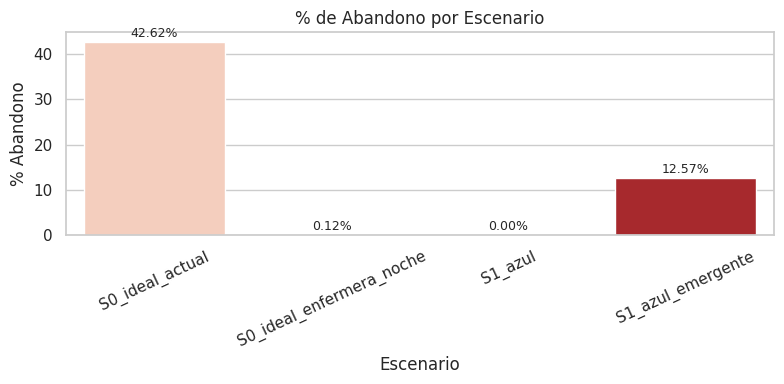

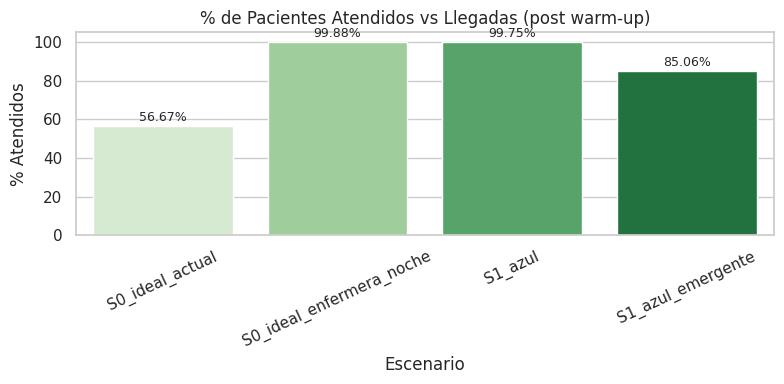

In [332]:
# Gráficos comparativos: % Abandono y Pacientes Atendidos
# ---------------------------------------------------------
# Utiliza el DataFrame 'escenarios_df' generado en la celda anterior.
# Produce dos gráficos de barras para comunicar diferencias entre escenarios.

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Gráfico 1: % de abandono por escenario
plt.figure(figsize=(8,4))
sns.barplot(data=escenarios_df, x='escenario', y='abandono_%', palette='Reds',hue='escenario', legend=False)
plt.title('% de Abandono por Escenario')
plt.ylabel('% Abandono')
plt.xlabel('Escenario')
plt.xticks(rotation=25)
for i, v in enumerate(escenarios_df['abandono_%']):
    plt.text(i, v + max(escenarios_df['abandono_%']) * 0.01, f"{v:.2f}%", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# (Opcional) Porcentaje atendidos sobre total post warm-up
escenarios_df['%_atendidos'] = escenarios_df['atendidos'] / escenarios_df['total_post_warmup'] * 100
plt.figure(figsize=(8,4))
sns.barplot(data=escenarios_df, x='escenario', y='%_atendidos', palette='Greens', hue='escenario', legend=False)
plt.title('% de Pacientes Atendidos vs Llegadas (post warm-up)')
plt.ylabel('% Atendidos')
plt.xlabel('Escenario')
plt.xticks(rotation=25)
for i, v in enumerate(escenarios_df['%_atendidos']):
    plt.text(i, v + max(escenarios_df['%_atendidos']) * 0.01, f"{v:.2f}%", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


Resumen global abandono por color (todos los escenarios combinados):
      color  total_color  abandono_color  abandono_%
0      rojo           74              13   17.567568
1   naranja          456              60   13.157895
2  amarillo         1075             134   12.465116
3     verde         1700             238   14.000000
4      azul          524              84   16.030534


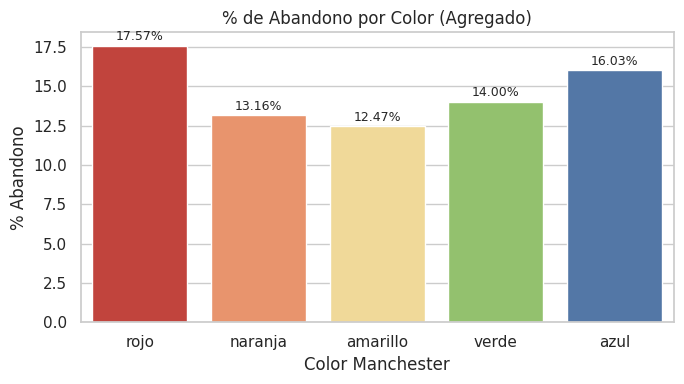

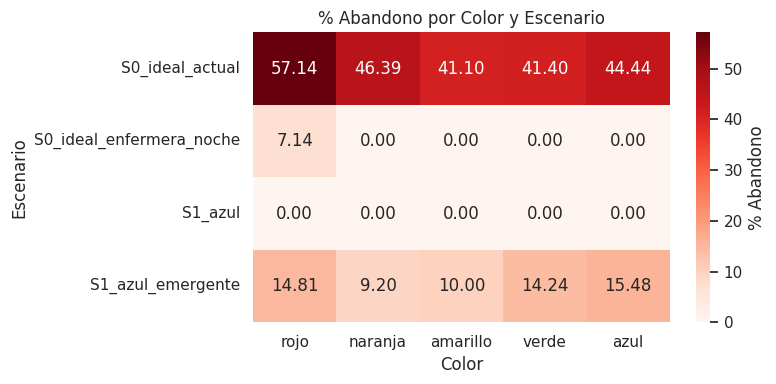

In [333]:
# Gráfico: % de Abandono por Color (agregado sobre todos los escenarios)
# ---------------------------------------------------------------------
# Usa los registros ya calculados en la celda de escenarios (abandono_color_records)
# evitando re-simular y manteniendo coherencia entre tablas y heatmap.
# Si no existen (ejecución aislada), se re-simulan como fallback.

import matplotlib.pyplot as plt
import seaborn as sns

color_abandono = []
if 'abandono_color_records' in globals() and abandono_color_records:
    color_abandono = abandono_color_records
else:
    print('[AVISO] No se encontraron registros previos; re-simulando escenarios para obtener abandono por color.')
    for sname, scfg in SCENARIOS.items():
        res = run_scenario(sname, scfg, seed=RANDOM_SEED)
        df = res['eventos']
        df_post = df[df['arrival_min'] >= WARMUP_MIN]
        totales_color = df_post.groupby('color').size()
        aband_color = df_post[df_post['abandoned']].groupby('color').size()
        for c in COLORS:
            total_c = totales_color.get(c, 0)
            aband_c = aband_color.get(c, 0)
            pct = (aband_c / total_c * 100) if total_c > 0 else float('nan')
            color_abandono.append({
                'escenario': sname,
                'color': c,
                'abandono_%': pct,
                'total_color': total_c,
                'abandono_color': aband_c,
            })

abandono_df = pd.DataFrame(color_abandono)
# Agregación global (todas las llegadas de todos los escenarios) por color
abandono_global = (
    abandono_df.groupby('color', as_index=False).agg(
        total_color=('total_color', 'sum'),
        abandono_color=('abandono_color', 'sum')
    )
)
abandono_global['abandono_%'] = abandono_global['abandono_color'] / abandono_global['total_color'] * 100
# Mantener orden lógico de colores Manchester
abandono_global['color'] = pd.Categorical(abandono_global['color'], categories=COLORS, ordered=True)
abandono_global = abandono_global.sort_values('color').reset_index(drop=True)

print("Resumen global abandono por color (todos los escenarios combinados):")
print(abandono_global)

# Paleta personalizada asociada a colores Manchester
palette_map = {
    'rojo': '#d73027',
    'naranja': '#fc8d59',
    'amarillo': '#fee08b',
    'verde': '#91cf60',
    'azul': '#4575b4'
}

plt.figure(figsize=(7,4))
sns.barplot(data=abandono_global, x='color', y='abandono_%', palette=[palette_map[c] for c in abandono_global['color']], hue='color', legend=False)
plt.title('% de Abandono por Color (Agregado)')
plt.ylabel('% Abandono')
plt.xlabel('Color Manchester')
for i, row in abandono_global.iterrows():
    plt.text(i, row['abandono_%'] + (abandono_global['abandono_%'].max() * 0.01), f"{row['abandono_%']:.2f}%", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Heatmap por escenario y color (sin re-simulación)
pivot_ec = abandono_df.pivot(index='escenario', columns='color', values='abandono_%')
# Ordenar filas y columnas
pivot_ec = pivot_ec.reindex(index=list(SCENARIOS.keys()), columns=COLORS)
plt.figure(figsize=(8,4))
sns.heatmap(pivot_ec, annot=True, fmt='.2f', cmap='Reds', cbar_kws={'label':'% Abandono'}, vmin=0, vmax=abandono_df['abandono_%'].max())
plt.title('% Abandono por Color y Escenario')
plt.ylabel('Escenario')
plt.xlabel('Color')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


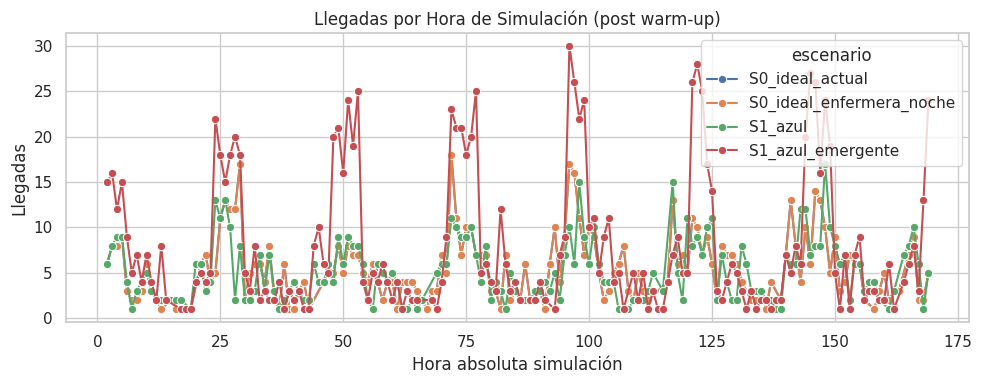

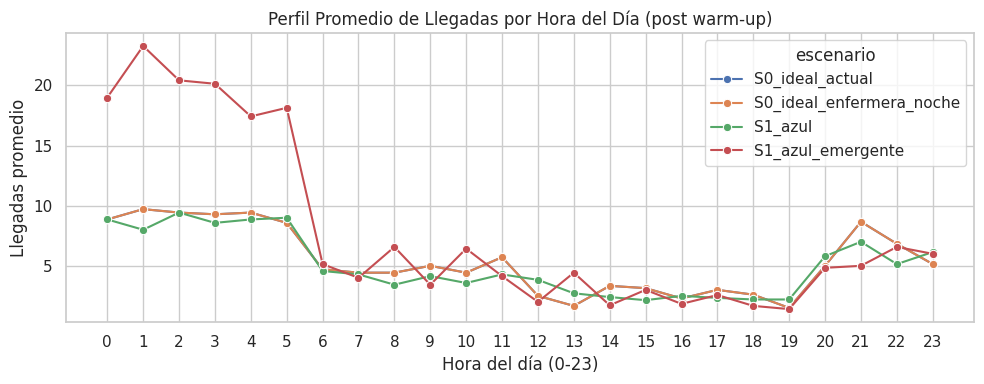

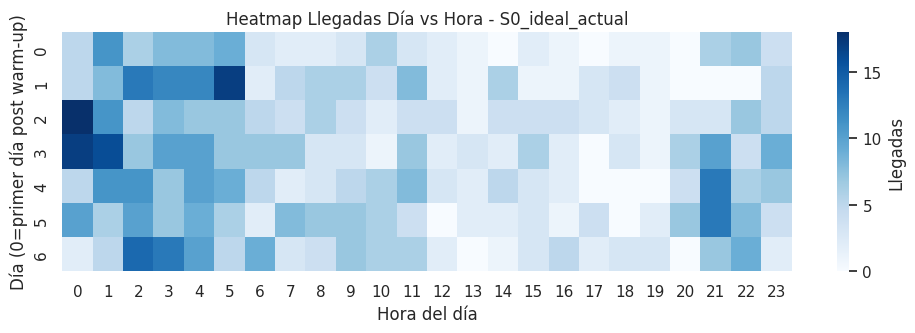

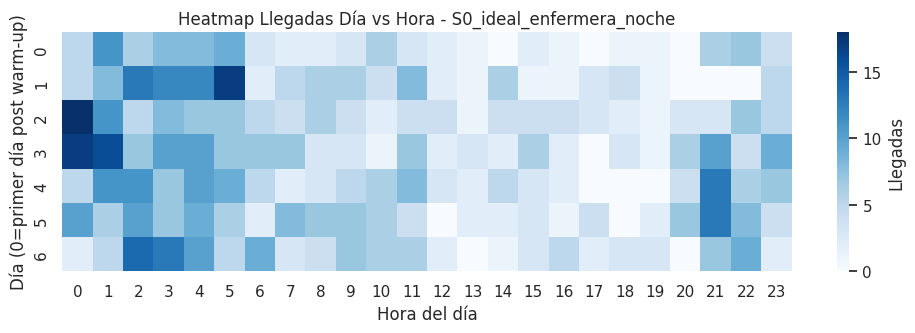

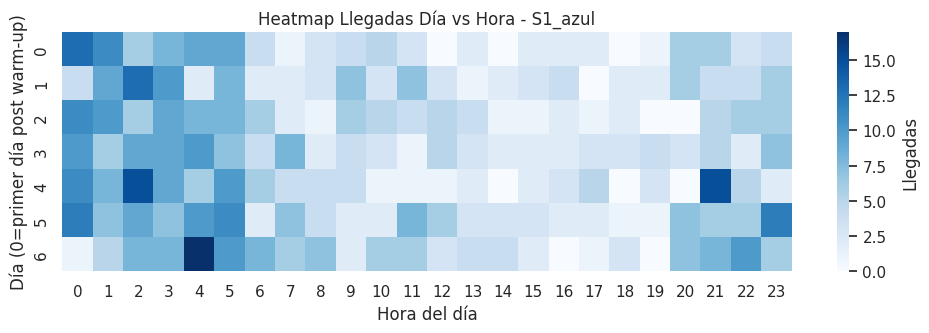

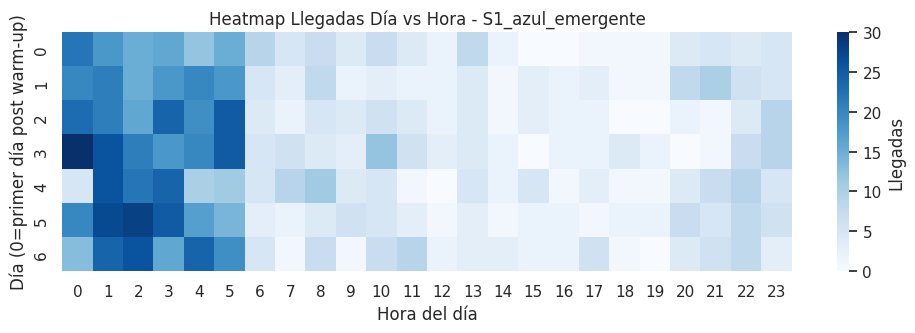


Resumen DataFrame llegadas_hora_df (primeras filas):
   hour_index  llegadas        escenario
0           2         6  S0_ideal_actual
1           3         8  S0_ideal_actual
2           4         8  S0_ideal_actual
3           5         9  S0_ideal_actual
4           6         3  S0_ideal_actual

Resumen DataFrame perfil_hora_dia_df (primeras filas):
   hour_of_day  llegadas        escenario
0            0  8.857143  S0_ideal_actual
1            1  9.714286  S0_ideal_actual
2            2  9.428571  S0_ideal_actual
3            3  9.285714  S0_ideal_actual
4            4  9.428571  S0_ideal_actual


In [334]:
# Gráficos de Llegadas por Hora en cada Escenario
# ------------------------------------------------
# Genera:
# 1. Serie temporal de llegadas por hora (post warm-up) para cada escenario.
# 2. Perfil promedio de llegadas por hora-del-día (0-23) para cada escenario.
# 3. Heatmap día (0-6) vs hora-del-día (0-23) de llegadas por escenario.
# Nota: Se reejecutan los escenarios para recolectar eventos completos.

import matplotlib.pyplot as plt
import seaborn as sns

llegadas_hora_list = []
perfil_hora_dia_list = []
heatmap_data = {}

for sname, scfg in SCENARIOS.items():
    res = run_scenario(sname, scfg, seed=RANDOM_SEED)
    df = res['eventos']
    # Filtrar post warm-up
    df_post = df[df['arrival_min'] >= WARMUP_MIN].copy()
    if df_post.empty:
        continue
    df_post['hour_index'] = (df_post['arrival_min'] // 60).astype(int)  # hora absoluta simulación
    df_post['hour_of_day'] = df_post['hour_index'] % 24
    df_post['day_index'] = ((df_post['arrival_min'] - WARMUP_MIN) // (60*24)).astype(int)

    # 1. Conteo por hora absoluta
    horas_abs = df_post.groupby('hour_index').size().reset_index(name='llegadas')
    horas_abs['escenario'] = sname
    llegadas_hora_list.append(horas_abs)

    # 2. Perfil promedio por hora-del-día (promedio sobre días)
    perfil = df_post.groupby(['day_index','hour_of_day']).size().reset_index(name='llegadas')
    perfil_prom = perfil.groupby('hour_of_day')['llegadas'].mean().reset_index()
    perfil_prom['escenario'] = sname
    perfil_hora_dia_list.append(perfil_prom)

    # 3. Heatmap día vs hora-del-día (matriz 7x24)
    matriz = perfil.pivot(index='day_index', columns='hour_of_day', values='llegadas').fillna(0)
    heatmap_data[sname] = matriz

llegadas_hora_df = pd.concat(llegadas_hora_list, ignore_index=True) if llegadas_hora_list else pd.DataFrame()
perfil_hora_dia_df = pd.concat(perfil_hora_dia_list, ignore_index=True) if perfil_hora_dia_list else pd.DataFrame()

# --- Gráfico 1: Serie temporal de llegadas por hora absoluta ---
if not llegadas_hora_df.empty:
    plt.figure(figsize=(10,4))
    sns.lineplot(data=llegadas_hora_df, x='hour_index', y='llegadas', hue='escenario', marker='o')
    plt.title('Llegadas por Hora de Simulación (post warm-up)')
    plt.xlabel('Hora absoluta simulación')
    plt.ylabel('Llegadas')
    plt.tight_layout()
    plt.show()
else:
    print('Sin datos para llegadas_hora_df')

# --- Gráfico 2: Perfil promedio hora-del-día ---
if not perfil_hora_dia_df.empty:
    plt.figure(figsize=(10,4))
    sns.lineplot(data=perfil_hora_dia_df, x='hour_of_day', y='llegadas', hue='escenario', marker='o')
    plt.title('Perfil Promedio de Llegadas por Hora del Día (post warm-up)')
    plt.xlabel('Hora del día (0-23)')
    plt.ylabel('Llegadas promedio')
    plt.xticks(range(0,24))
    plt.tight_layout()
    plt.show()
else:
    print('Sin datos para perfil_hora_dia_df')

# --- Gráfico 3: Heatmaps día vs hora-del-día por escenario ---
for sname, matriz in heatmap_data.items():
    plt.figure(figsize=(10,3.5))
    sns.heatmap(matriz, cmap='Blues', cbar_kws={'label':'Llegadas'}, annot=False)
    plt.title(f'Heatmap Llegadas Día vs Hora - {sname}')
    plt.ylabel('Día (0=primer día post warm-up)')
    plt.xlabel('Hora del día')
    plt.tight_layout()
    plt.show()

# DataFrames resultantes para posible exportación
print('\nResumen DataFrame llegadas_hora_df (primeras filas):')
print(llegadas_hora_df.head())
print('\nResumen DataFrame perfil_hora_dia_df (primeras filas):')
print(perfil_hora_dia_df.head())
